## Overview:

A sentiment analysis model for game screenshots using deep learning techniques. The goal was to classify game screenshots into three sentiment categories: Positive, Negative, and Neutral. We implemented a pipeline consisting of data preprocessing, model training, and evaluation.

### Data Preprocessing:

Preprocessing the dataset, which consisted of game screenshots along with their associated sentiment labels. To ensure data quality, we removed observations with null values in the sentiment column. Next, we aggregated the sentiment categories into three classes: Positive, Negative, and Neutral, based on a mapping dictionary. Visualizing the distribution of aggregated sentiment classes helped us understand the dataset's class balance.

Sampling was performed to balance the class distribution, ensuring each sentiment class had a proportional representation in the training data. This step involved selecting a subset of samples for each class based on desired proportions. The resulting sampled dataset was used for model training.

### Model Training and Evaluation:

We employed a convolutional neural network (CNN) architecture, leveraging transfer learning with the pre-trained ResNet-50 model. This architecture has shown effectiveness in various computer vision tasks. To prevent overfitting, we applied data augmentation techniques tailored to each sentiment class, such as random flips, color jitter, and random rotation. Class weighting and early stopping were also utilized to mitigate overfitting and improve model generalization.

During training, we monitored the training and validation loss, as well as accuracy, across multiple epochs. Visualizing confusion matrices provided insights into the model's performance on both the training and validation sets. Early stopping was implemented to prevent overfitting, ensuring the model's optimal generalization performance.

## Preprocessing

###  Importing Datasets

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import zipfile
import os

# Path to the zip file containing images
zip_path = '/content/drive/MyDrive/AA/images-small.zip'

# Extract the zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content/images_small')# Here you need to uplaod the images zip file in the directory and add the path

# Check the extracted files
print(os.listdir('/content/images_small')) # Here add the path as well.


In [ ]:
import json

# Path to the dataset.json file
dataset_json_path = '/content/dataset.json'

# Load the metadata from dataset.json
with open(dataset_json_path, 'r') as f:
    data = json.load(f)

# Replace .jpg with .webp in screenshot filenames
for game in data:
    game['screenshots'] = [screenshot.replace('.jpg', '.webp') for screenshot in game['screenshots']]

# Print out a few samples to verify the changes
print(data[:5])

### Dropping Missing values

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Convert the data to a DataFrame
df = pd.DataFrame(data)

# Remove observations with null values in the 'sentiment' column
df = df.dropna(subset=['sentiment'])

### Aggregating Classes into 3 Classes

In [ ]:
import matplotlib.pyplot as plt

# Define mapping dictionary for aggregating sentiment categories
sentiment_mapping = {
    'Positive': 'Positive',
    'Very Positive': 'Positive',
    'Mixed': 'Neutral',
    'Mostly Positive': 'Positive',
    'Overwhelmingly Positive': 'Positive',
    'Mostly Negative': 'Negative',
    'Negative': 'Negative',
    'Very Negative': 'Negative',
    'Overwhelmingly Negative': 'Negative'
}

# Map sentiment categories to aggregated classes
df['sentiment_aggregated'] = df['sentiment'].map(sentiment_mapping)

# Plot the distribution of aggregated sentiment classes
plt.figure(figsize=(8, 6))
df['sentiment_aggregated'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Distribution of Aggregated Sentiment Classes')
plt.xlabel('Sentiment Class')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()


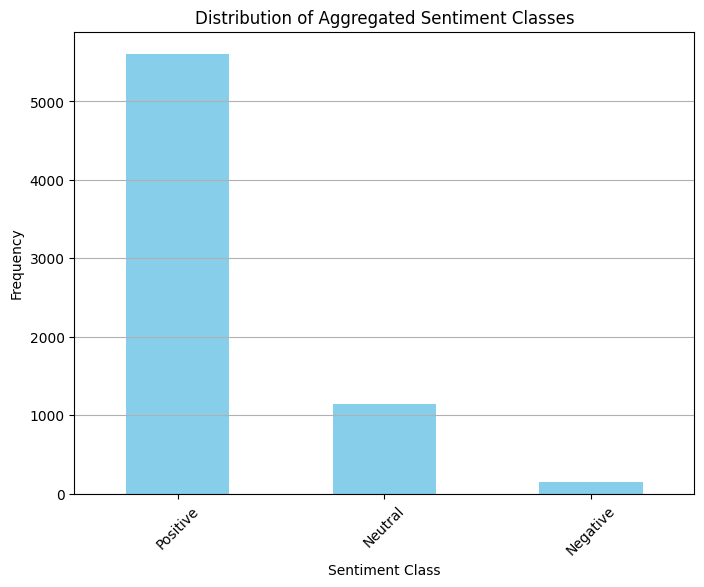

### Creating a sample with the same distribution of each class

In [ ]:
from sklearn.model_selection import train_test_split

# Define the desired proportions for each class in the sample
proportions = {
    'Positive': 5608 / (5608 + 1144 + 152),  # Proportion of positive class
    'Neutral': 1144 / (5608 + 1144 + 152),    # Proportion of neutral class
    'Negative': 152 / (5608 + 1144 + 152)     # Proportion of negative class
}

# Calculate the number of samples for each class based on the desired proportions
num_samples_per_class = {sentiment_class: int(proportion * 500) for sentiment_class, proportion in proportions.items()}

# Initialize an empty DataFrame to store the sampled data
sampled_df = pd.DataFrame()

# Iterate over each class
for sentiment_class, num_samples in num_samples_per_class.items():
    # Filter the original DataFrame for the current class
    class_df = df[df['sentiment_aggregated'] == sentiment_class]

    # Take a random sample from the current class, ensuring it doesn't exceed the target number of samples
    sampled_class_df = class_df.sample(min(len(class_df), num_samples), random_state=42)

    # Append the sampled data to the DataFrame storing the sampled data
    sampled_df = pd.concat([sampled_df, sampled_class_df], ignore_index=True)


### Creating a dataframe with image path and corresponding label

In [ ]:
import pandas as pd
import os
from sklearn.model_selection import train_test_split

# Assume 'sampled_df' contains the sampled data and 'images_folder' is the folder containing the images
images_folder = '/content/images_small/images'

# Create a new DataFrame to store individual images, their labels, and their game IDs
image_data = []
for index, row in sampled_df.iterrows():
    game_id = row['appid']  # Assuming 'game_id' is the column name for the game IDs in sampled_df
    sentiment_label = row['sentiment_aggregated']
    for image_filename in row['screenshots']:
        image_path = os.path.join(images_folder, image_filename)
        image_data.append({'appid': game_id, 'image_path': image_path, 'label': sentiment_label})

image_df = pd.DataFrame(image_data)

# Check the first few rows of the resulting DataFrame
image_df.head()

### Splitting the dataset

In [ ]:
# Split the data into training and testing sets
train_df, test_df = train_test_split(image_df, test_size=0.2, stratify=image_df['label'], random_state=42)

# Print the distribution of labels in the training and testing sets
print("Training set label distribution:")
print(train_df['label'].value_counts())
print("\nTesting set label distribution:")
print(test_df['label'].value_counts())

### Mapping each sentiment into a label

In [ ]:
label_mapping = {'Positive': 2, 'Negative': 0, 'Neutral': 1}
train_df['label'] = train_df['label'].map(label_mapping)
test_df['label'] = test_df['label'].map(label_mapping)

train_df.head()

## Fine-Tuning Resnet50 model

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models
from PIL import Image
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Define transformations for data augmentation
positive_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

# For negative class data augmentation
negative_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomRotation(degrees=30),
    transforms.RandomResizedCrop(size=64, scale=(0.8, 1.0)),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor()
])

# For neutral class data augmentation
neutral_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomRotation(degrees=30),
    transforms.RandomResizedCrop(size=64, scale=(0.8, 1.0)),
    transforms.RandomVerticalFlip(),  # Add random vertical flip
    transforms.ToTensor()
])

# Define the dataset class
class CustomDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_name = self.df.iloc[idx, 1]
        image = Image.open(img_name).convert("RGB")
        label = int(self.df.iloc[idx, 2])

        if self.transform:
            if label == 2:  # Positive class
                image = self.transform['positive'](image)
            elif label == 0:  # Negative class
                image = self.transform['negative'](image)
            elif label == 1:  # Neutral class
                image = self.transform['neutral'](image)

        return image, label

# Create datasets and dataloaders
positive_samples = 1500
negative_samples = len(train_df[train_df['label'] == 0])
neutral_samples = len(train_df[train_df['label'] == 1])


# For the positive class, select a subset of 1500 samples randomly
positive_df = train_df[train_df['label'] == 2].sample(positive_samples, replace=True)
neutral_df = train_df[train_df['label'] == 1]
negative_df = train_df[train_df['label'] == 0]

# Concatenate the selected samples for each class
augmented_train_df = pd.concat([positive_df, negative_df, neutral_df])

# Apply transformations based on class label
transform = {
    'positive': positive_transform,
    'negative': negative_transform,
    'neutral': neutral_transform
}

# Create the custom dataset
dataset = CustomDataset(augmented_train_df, transform=transform)

# Split the dataset into training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Test dataset
# Assuming test_df is the test DataFrame
test_dataset = CustomDataset(test_df, transform=positive_transform)  # Use positive_transform for test
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Calculate class weights
class_counts = augmented_train_df['label'].value_counts().sort_index()
class_weights = 1.0 / class_counts
weights = class_weights.values

# Convert weights to a tensor and move to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
weights = torch.tensor(weights, dtype=torch.float32).to(device)

# Load pre-trained ResNet model
resnet = models.resnet50(pretrained=True)
num_features = resnet.fc.in_features

# Modify the final fully connected layer
resnet.fc = nn.Linear(num_features, 3)
resnet = resnet.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss(weight=weights)
optimizer = optim.Adam(resnet.parameters(), lr=0.001)

# Early stopping parameters
patience = 3
best_val_loss = float('inf')
best_epoch = 0
best_model_path = 'best_model.pth'
patience_counter = 0

# Train the model
for epoch in range(11):  # Number of epochs
    running_loss = 0.0
    correct = 0
    total = 0
    all_train_preds = []
    all_train_labels = []

    # Initialize tqdm progress bar for training
    train_pbar = tqdm(train_loader, desc=f'Training Epoch {epoch+1}', leave=True)

    for inputs, labels in train_pbar:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = resnet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_train_preds.extend(predicted.tolist())
        all_train_labels.extend(labels.tolist())

        # Update training progress bar description
        train_pbar.set_postfix({'loss': running_loss / len(train_loader), 'accuracy': correct / total})

    # Generate training confusion matrix
    train_cm = confusion_matrix(all_train_labels, all_train_preds)

    # Plot training confusion matrix heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(train_cm, annot=True, fmt='g', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Training Confusion Matrix - Epoch {epoch+1}')
    plt.show()

    # Validation loop
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0
    val_preds = []
    val_labels_list = []

    # Initialize tqdm progress bar for validation
    val_pbar = tqdm(val_loader, desc=f'Validation Epoch {epoch+1}', leave=True)

    # Disable gradient calculation
    resnet.eval()
    with torch.no_grad():
        for val_inputs, val_labels in val_pbar:
            val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
            val_outputs = resnet(val_inputs)
            val_loss = criterion(val_outputs, val_labels)
            val_running_loss += val_loss.item()
            _, val_predicted = torch.max(val_outputs.data, 1)
            val_total += val_labels.size(0)
            val_correct += (val_predicted == val_labels).sum().item()
            val_preds.extend(val_predicted.tolist())
            val_labels_list.extend(val_labels.tolist())

            # Update validation progress bar description
            val_pbar.set_postfix({'loss': val_running_loss / len(val_loader), 'accuracy': val_correct / val_total})

    # Generate validation confusion matrix
    val_cm = confusion_matrix(val_labels_list, val_preds)

    # Plot validation confusion matrix heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(val_cm, annot=True, fmt='g', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Validation Confusion Matrix - Epoch {epoch+1}')
    plt.show()

    # Calculate validation accuracy and loss
    val_accuracy = val_correct / val_total
    val_loss = val_running_loss / len(val_loader)

    print(f'Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}')

    # Save the best model if validation loss improves
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_epoch = epoch + 1
        torch.save(resnet.state_dict(), best_model_path)
        patience_counter = 0  # Reset patience counter
    else:
        patience_counter += 1

    # Early stopping
    if patience_counter >= patience:
        print(f'Early stopping at epoch {epoch + 1}')
        break

    resnet.train()

print(f'Best Validation Loss: {best_val_loss} at Epoch {best_epoch}')


Best Validation Loss: 0.7544222197362355 at Epoch 2

### Testing the model on test set

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_name = self.df.iloc[idx, 1]
        image = Image.open(img_name).convert("RGB")
        label = int(self.df.iloc[idx, 2])

        if self.transform:
            image = self.transform(image)

        return image, label

# Define transformations for test data
test_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

# Create the custom dataset and dataloader for test data
test_dataset = CustomDataset(test_df, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


# Evaluate the model on test data
resnet.eval()  # Set the model to evaluation mode
test_correct = 0
test_total = 0
all_test_preds = []
all_test_labels = []

# Disable gradient calculation
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # Move tensors to the same device as the model
        outputs = resnet(inputs)
        _, predicted = torch.max(outputs.data, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()
        all_test_preds.extend(predicted.tolist())
        all_test_labels.extend(labels.tolist())

# Compute test accuracy
test_accuracy = test_correct / test_total
print(f'Test Accuracy: {test_accuracy}')

# Generate confusion matrix for test data
test_cm = confusion_matrix(all_test_labels, all_test_preds)

# Plot confusion matrix heatmap for test data
plt.figure(figsize=(8, 6))
sns.heatmap(test_cm, annot=True, fmt='g', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Test Data')
plt.show()

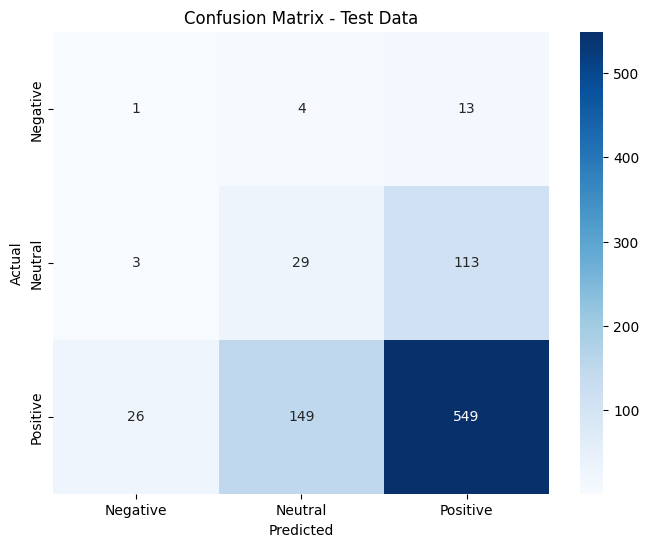

                    precision    recall  f1-score   

          Negative       0.03      0.06      0.04        
          Neutral       0.16      0.20      0.18       
         Positive       0.81      0.76      0.78       

          accuracy                           0.65       
        macro avg       0.34      0.34      0.33       
     weighted avg       0.69      0.65      0.67       




## Results:


Our sentiment analysis model achieved varied F1-scores across different sentiment classes. While it demonstrated a strong F1-score of 0.78 for the Positive class, indicating balanced precision and recall, its performance was notably weaker for Negative and Neutral sentiments. The F1-scores for Negative and Neutral classes were only 0.04 and 0.18, respectively, reflecting challenges in correctly identifying instances of these sentiments.


## Illustratings model's predictions on a couple of test images

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Set the model to evaluation mode
resnet.eval()

# Function to predict class labels for images in test_loader
def predict_test_images(model, test_loader):
    predictions = []
    images = []
    labels = []
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            predictions.extend(preds.cpu().numpy())
            images.extend(inputs.cpu().numpy())
            labels.extend(targets.cpu().numpy())
    return np.array(predictions), np.array(images), np.array(labels)

# Predict class labels for test images
test_preds, test_images, test_labels = predict_test_images(resnet, test_loader)

# Define class labels
class_labels = ['Negative', 'Neutral', 'Positive']

# Plot a few test images with their predicted and true labels
num_images_to_plot = 5  # Number of images to plot
plt.figure(figsize=(15, 10))
for i in range(num_images_to_plot):
    plt.subplot(1, num_images_to_plot, i + 1)
    plt.imshow(np.transpose(test_images[i], (1, 2, 0)))  # Reshape image for plotting
    plt.axis('off')
    plt.title(f'Predicted: {class_labels[test_preds[i]]}\nTrue: {class_labels[test_labels[i]]}')
plt.show()

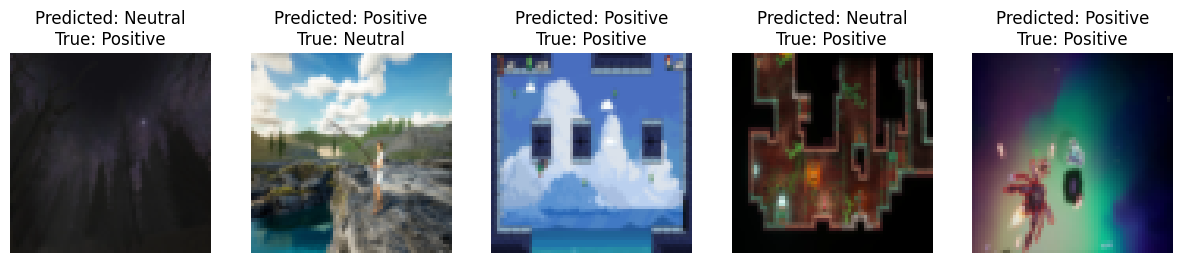